# The P-Median Problem for Emergency Response & Disaster Relief (Solved with cuOpt)

## Introduction

The **P-Median Problem** is a classical facility location problem in operations research. Given a set of demand points (affected populations) and a set of potential facility locations, the goal is to select exactly **p** facilities to open such that the total (weighted) distance from all demand points to their nearest open facility is minimized.

This notebook demonstrates how to use **NVIDIA cuOpt's Python MIP interface** to solve the P-Median problem for **emergency response and disaster relief** scenarios. cuOpt provides GPU-accelerated optimization that can significantly speed up solving large-scale MIP problems—critical when rapid decision-making is needed during emergencies.

### Real-World Applications in Emergency Management

- **Emergency shelters**: Positioning evacuation shelters to minimize travel distance for displaced populations
- **Medical aid stations**: Locating field hospitals or first-aid posts after earthquakes or floods
- **Supply distribution centers**: Placing relief supply hubs (food, water, medicine) for efficient distribution
- **Search and rescue bases**: Siting rescue operation headquarters to minimize response time
- **Temporary housing**: Selecting sites for temporary housing camps after large-scale disasters

## Real-World Example: Earthquake Emergency Shelter Placement

Consider an emergency management agency responding to a **major earthquake** that has displaced thousands of residents across a metropolitan region. The agency must rapidly deploy **emergency shelters** (facilities) to accommodate **affected population zones** (clients). Each zone has a certain **population count** (weight) requiring shelter, and the agency has limited resources to establish only a fixed number of shelters. The objective is to minimize the total "cost" of evacuating all affected populations to shelters, where cost is proportional to travel distance.

In this notebook:
- **Clients** = Affected population zones requiring emergency shelter
- **Facilities** = Potential shelter locations (schools, stadiums, community centers, open fields)
- **Weights** = Population count in each affected zone (people needing shelter)
- **Cost matrix** = Travel distance (or evacuation time) between zones and potential shelter sites
- **p** = Resource constraint on how many shelters can be established

## Mathematical Formulation (MIP)

**Sets:**
- $I$ = set of affected population zones (demand points), indexed by $i$
- $J$ = set of potential shelter locations, indexed by $j$

**Parameters:**
- $d_{ij}$ = evacuation distance/time from zone $i$ to shelter $j$
- $a_i$ = population count (demand weight) of zone $i$
- $p$ = number of shelters to establish

**Decision Variables:**
- $y_j \in \{0,1\}$ = 1 if shelter $j$ is established, 0 otherwise
- $x_{ij} \in \{0,1\}$ = 1 if zone $i$ is assigned to shelter $j$, 0 otherwise

**Objective:** Minimize total weighted evacuation distance
$$\min \sum_{i \in I} \sum_{j \in J} a_i \cdot d_{ij} \cdot x_{ij}$$

**Subject to:**

1. **Assignment constraint** - Each zone must be assigned to exactly one shelter:
$$\sum_{j \in J} x_{ij} = 1 \quad \forall i \in I$$

2. **Shelter count constraint** - Exactly $p$ shelters must be established:
$$\sum_{j \in J} y_j = p$$

3. **Linking constraint** - A zone can only be assigned to an established shelter:
$$x_{ij} \leq y_j \quad \forall i \in I, j \in J$$

4. **Binary constraints:**
$$x_{ij}, y_j \in \{0,1\}$$

## cuOpt MIP Solver

cuOpt provides a high-level Python API similar to other MIP solvers. Key features:
- **Problem class**: Define variables, constraints, and objectives using intuitive syntax
- **GPU acceleration**: Leverage NVIDIA GPUs for faster solving—essential for time-critical emergency decisions
- **Flexible interface**: Variables support arithmetic operations for building expressions

**Requirements:**
- `matplotlib`, `numpy`, `scipy`
- `cuopt` (NVIDIA cuOpt with MIP support)


## Environment Setup

This notebook requires:
- **NVIDIA GPU** with CUDA support
- **cuOpt** GPU-accelerated optimization library

If running on **Google Colab**:
1. Go to **Runtime → Change runtime type**
2. Set **Hardware accelerator** to **GPU** (T4 recommended)
3. Click **Save** and run the cells below


In [ ]:
# GPU Detection - Run this first to verify GPU is available
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>

            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>

            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>

            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()


True

In [ ]:
# Install cuOpt 25.12 (required for GPU-accelerated optimization)
# Using CUDA 12 package (compatible with CUDA 12.x including 12.9)

%pip install --upgrade --extra-index-url=https://pypi.nvidia.com "cuopt-cu12>=25.12,<25.13" "nvidia-nvjitlink-cu12" -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.9/515.9 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.4/880.4 kB 239.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 243.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.3/642.3 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 236.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 227.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 MB 137.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 220.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

from cuopt.linear_programming.problem import Problem, VType, sense
from cuopt.linear_programming.solver_settings import SolverSettings

%config InlineBackend.figure_format = "retina"

print("✓ All imports successful")


✓ All imports successful


## Data Generation

We simulate an earthquake emergency response scenario by generating random data:

- **Affected population zones (clients)**: Random locations in a disaster region (imagine a 50km × 50km metropolitan area)
- **Potential shelter sites (facilities)**: Candidate locations where emergency shelters could be established (schools, stadiums, community centers)
- **Population demand (weights)**: Each zone has varying population counts requiring shelter
- **Cost matrix**: Euclidean distances representing evacuation travel distance between zones and potential shelter sites

**Scenario Context**: A magnitude 7.2 earthquake has struck a metropolitan region. Multiple neighborhoods have been damaged, displacing residents who need immediate shelter. The emergency management agency must decide which shelter sites to activate from a pre-identified list of suitable locations.


Total population requiring shelter: 1,157 people
Average population per zone: 6 people
Cost Matrix Shape: (200, 50)


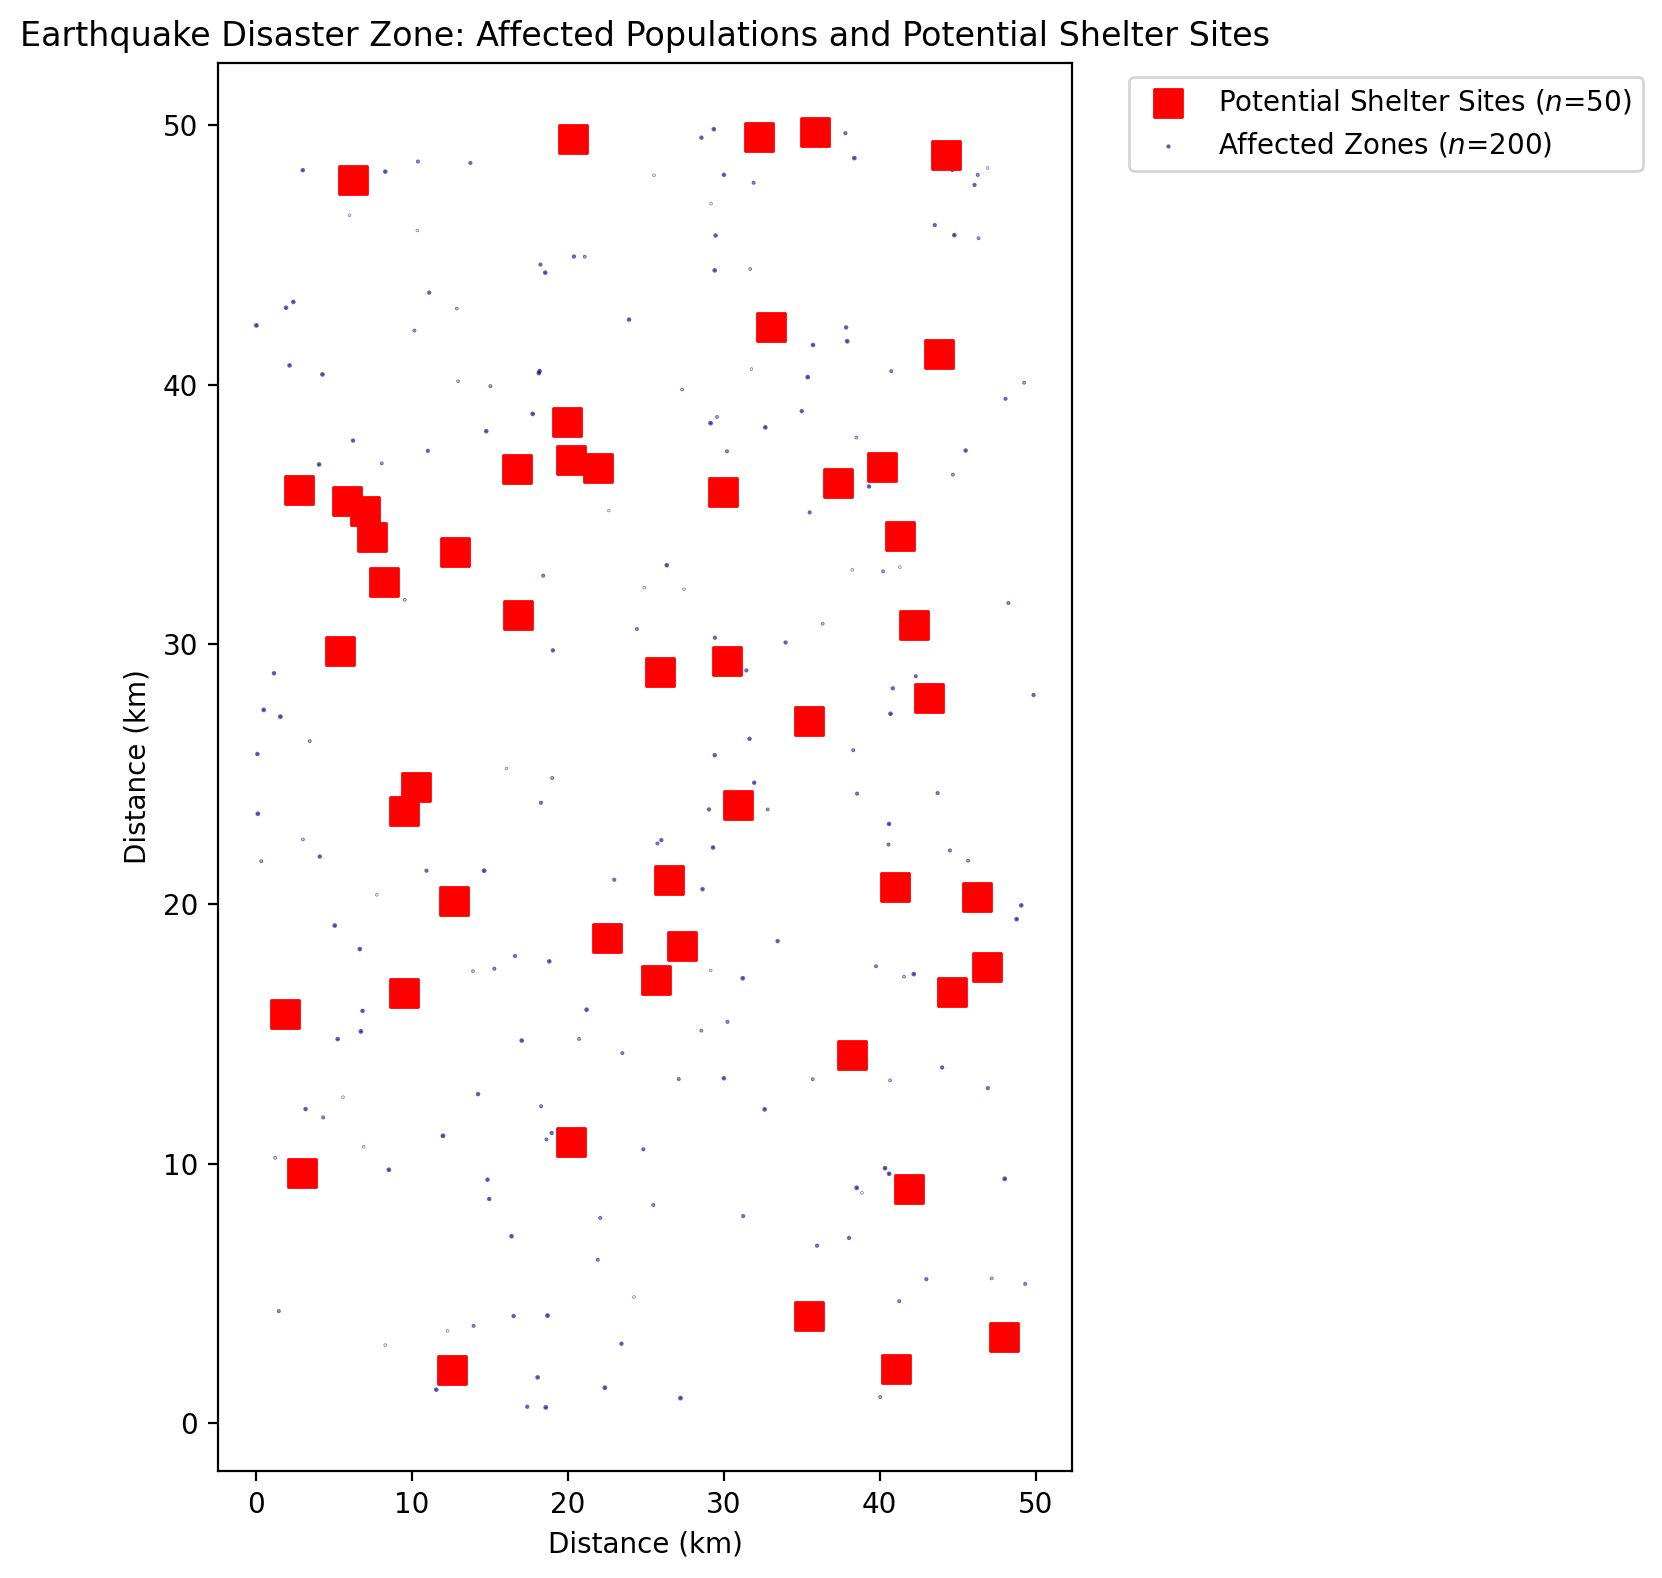

In [ ]:
# Constants for disaster scenario
ZONE_COUNT = 200           # Number of affected population zones
SHELTER_COUNT = 50         # Number of potential shelter sites
P_SHELTERS = 8             # Number of shelters to establish (resource constraint)
ZONE_SEED = 5              # Random seed for reproducibility
SHELTER_SEED = 6
COORD_RANGE = 50           # 50km x 50km disaster area

# Generate random locations for affected zones
np.random.seed(ZONE_SEED)
zone_coords = np.random.rand(ZONE_COUNT, 2) * COORD_RANGE

# Generate random locations for potential shelter sites
np.random.seed(SHELTER_SEED)
shelter_coords = np.random.rand(SHELTER_COUNT, 2) * COORD_RANGE

# Generate population demand weights
np.random.seed(0)
population_demand = np.random.randint(1, 12, ZONE_COUNT)

# Calculate cost matrix (Euclidean distance in km)
cost_matrix = cdist(zone_coords, shelter_coords)

print(f"Total population requiring shelter: {population_demand.sum():,} people")
print(f"Average population per zone: {population_demand.mean():.0f} people")
print(f"Cost Matrix Shape: {cost_matrix.shape}")

# Plot the disaster scenario
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(shelter_coords[:, 0], shelter_coords[:, 1],
           color="red", s=100, marker="s", zorder=2,
           label=f"Potential Shelter Sites ($n$={SHELTER_COUNT})")
ax.scatter(zone_coords[:, 0], zone_coords[:, 1],
           color="darkblue", s=population_demand/20, alpha=0.6,
           label=f"Affected Zones ($n$={ZONE_COUNT})")
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Distance (km)")
ax.set_title("Earthquake Disaster Zone: Affected Populations and Potential Shelter Sites")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


## Helper Function: Solve P-Median with cuOpt

We define a reusable function that builds and solves P-Median variants using cuOpt's Python MIP interface. The function demonstrates key cuOpt API patterns:

### cuOpt API Highlights

1. **Creating a Problem**: `Problem(name)` creates a new optimization problem
2. **Adding Variables**: `problem.addVariable(lb, ub, vtype, name)` with `VType.INTEGER` for binary (0/1) variables
3. **Building Expressions**: Variables support arithmetic (`+`, `-`, `*`) for building linear expressions
4. **Adding Constraints**: Use comparison operators (`<=`, `>=`, `==`) to create constraints
5. **Setting Objective**: `problem.setObjective(expr, sense=sense.MINIMIZE)`
6. **Solver Settings**: `SolverSettings()` configures time limits, tolerances, etc.
7. **Solving**: `problem.solve(settings)` runs the optimizer
8. **Extracting Results**: Access `problem.Status`, `problem.ObjValue`, and `var.getValue()`

### Supported Emergency Response Variants

1. **Basic P-Median**: Select p shelters to minimize total weighted evacuation distance
2. **Capacitated P-Median**: Each shelter has a maximum occupancy limit
3. **Predefined shelters**: Force certain locations (existing infrastructure) to be used
4. **Fulfill capacity**: Force predefined shelters to operate at exactly their capacity (government mandates)


In [ ]:
def solve_pmedian_cuopt(
    cost_matrix,
    weights,
    p,
    capacities=None,
    predefined_indices=None,
    fulfill_predefined=False,
    name="p-median",
    time_limit=None
):
    """
    Solve the P-Median problem for emergency shelter placement using cuOpt's MIP interface.

    Parameters
    ----------
    cost_matrix : ndarray
        Matrix of shape (num_zones, num_shelters) with evacuation distances
    weights : ndarray
        Population demand for each affected zone
    p : int
        Number of shelters to establish
    capacities : ndarray, optional
        Maximum occupancy limit for each shelter
    predefined_indices : array-like, optional
        Indices of shelters that must be established (existing infrastructure)
    fulfill_predefined : bool
        If True, predefined shelters must operate at exactly their capacity
    name : str
        Name for the problem (used in MPS export)
    time_limit : float, optional
        Time limit in seconds for the solver

    Returns
    -------
    problem : Problem
        The cuOpt Problem object after solving
    open_shelters : list
        Indices of established shelters
    shelter_to_zones : list of lists
        For each shelter, list of assigned zone indices
    """
    num_zones, num_shelters = cost_matrix.shape

    # Create cuOpt Problem
    problem = Problem(name)

    # --- Variables ---
    # y_j: 1 if shelter j is established (binary = integer with bounds [0,1])
    y = []
    for j in range(num_shelters):
        var = problem.addVariable(lb=0, ub=1, vtype=VType.INTEGER, name=f"y_{j}")
        y.append(var)

    # x_ij: 1 if zone i is assigned to shelter j (binary)
    x = {}
    for i in range(num_zones):
        for j in range(num_shelters):
            x[i, j] = problem.addVariable(lb=0, ub=1, vtype=VType.INTEGER, name=f"x_{i}_{j}")

    # --- Objective ---
    # Minimize total weighted evacuation distance: sum(population_i * distance_ij * x_ij)
    obj_expr = sum(
        weights[i] * cost_matrix[i, j] * x[i, j]
        for i in range(num_zones)
        for j in range(num_shelters)
    )
    problem.setObjective(obj_expr, sense=sense.MINIMIZE)

    # --- Constraints ---

    # 1. Each zone must be assigned to exactly one shelter
    for i in range(num_zones):
        problem.addConstraint(
            sum(x[i, j] for j in range(num_shelters)) == 1,
            name=f"assign_zone_{i}"
        )

    # 2. Exactly p shelters must be established
    problem.addConstraint(
        sum(y[j] for j in range(num_shelters)) == p,
        name="num_shelters"
    )

    # 3. Linking constraints: Zone can only be assigned to established shelter
    # x_ij <= y_j
    for i in range(num_zones):
        for j in range(num_shelters):
            problem.addConstraint(x[i, j] <= y[j], name=f"link_{i}_{j}")

    # 4. Shelter Capacities (Optional)
    if capacities is not None:
        for j in range(num_shelters):
            # Total population assigned to shelter j must respect capacity
            is_predefined = predefined_indices is not None and j in predefined_indices

            population_served = sum(weights[i] * x[i, j] for i in range(num_zones))

            if is_predefined and fulfill_predefined:
                # Force exact capacity usage (government mandate)
                problem.addConstraint(
                    population_served == capacities[j] * y[j],
                    name=f"capacity_fulfill_{j}"
                )
            else:
                # Standard capacity limit
                problem.addConstraint(
                    population_served <= capacities[j] * y[j],
                    name=f"capacity_limit_{j}"
                )

    # 5. Predefined Shelters (Optional) - Existing infrastructure must be used
    if predefined_indices is not None:
        for idx in predefined_indices:
            problem.addConstraint(y[idx] == 1, name=f"predefined_{idx}")

    # --- Export MPS ---
    problem.writeMPS(f"{name}.mps")
    print(f"Problem exported to {name}.mps")

    # --- Configure Solver Settings ---
    settings = SolverSettings()
    if time_limit is not None:
        # Note: set_parameter expects string values per cuOpt API
        settings.set_parameter("time_limit", str(float(time_limit)))

    # Enable console logging to see solver progress
    settings.set_parameter("log_to_console", "true")

    # --- Solve ---
    problem.solve(settings)

    status = problem.Status.name if hasattr(problem.Status, 'name') else str(problem.Status)
    print(f"Solve Status: {status}")

    # Check if we have a valid solution
    if not np.isnan(problem.ObjValue):
        print(f"Objective Value: {problem.ObjValue:.3f}")

        # Extract solution: which shelters are established
        shelter_solution = [j for j in range(num_shelters) if y[j].getValue() > 0.5]

        # Map shelter to zones
        shelter2zones = [[] for _ in range(num_shelters)]
        for j in range(num_shelters):
            for i in range(num_zones):
                if x[i, j].getValue() > 0.5:
                    shelter2zones[j].append(i)

        return problem, shelter_solution, shelter2zones
    else:
        print("No solution found.")
        return None, None, None


def plot_solution(zone_coords, shelter_coords, open_shelters, allocation, title="Emergency Shelter Allocation"):
    """Plot the solution showing zone-to-shelter assignments."""
    num_shelters = len(shelter_coords)

    # Generate colors for each active shelter
    cmap = plt.colormaps.get_cmap('tab20').resampled(len(open_shelters))
    shelter_colors = {shelter: cmap(i) for i, shelter in enumerate(open_shelters)}

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot inactive shelter sites as grey crosses
    inactive_shelters = [j for j in range(num_shelters) if j not in open_shelters]
    if inactive_shelters:
        ax.scatter(
            shelter_coords[inactive_shelters, 0],
            shelter_coords[inactive_shelters, 1],
            c='lightgrey', marker='x', s=80, zorder=1, label='Inactive Shelter Sites'
        )

    # Plot zones and active shelters by color
    for shelter_idx in open_shelters:
        color = shelter_colors[shelter_idx]
        zones = allocation[shelter_idx]

        if zones:
            # Plot zones assigned to this shelter
            ax.scatter(
                zone_coords[zones, 0],
                zone_coords[zones, 1],
                c=[color], s=15, alpha=0.7, zorder=2
            )
            # Draw evacuation routes from zones to shelter
            for zone in zones:
                ax.plot(
                    [zone_coords[zone, 0], shelter_coords[shelter_idx, 0]],
                    [zone_coords[zone, 1], shelter_coords[shelter_idx, 1]],
                    c=color, alpha=0.15, linewidth=0.5, zorder=1
                )

        # Plot the active shelter as a star
        ax.scatter(
            shelter_coords[shelter_idx, 0],
            shelter_coords[shelter_idx, 1],
            c=[color], s=250, marker='*', edgecolors='black', linewidths=0.5, zorder=3
        )

    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Distance (km)")
    ax.set_title(title)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


---

# Part I: P-Median Variants for Emergency Shelter Placement

We now solve four progressively constrained variants of the P-Median problem, each adding real-world complexity:

1. **Classic** → Baseline (unconstrained)
2. **Capacitated** → Add occupancy limits
3. **Predefined** → Force use of existing infrastructure  
4. **Fulfill Capacity** → Mandate full utilization of predefined shelters

---

## 1. Classic P-Median: Basic Emergency Shelter Selection

The basic formulation: select exactly **p** emergency shelters from the candidate locations to minimize the total weighted evacuation distance. This represents an idealized first-response scenario where:
- There are no capacity limits on shelters (unlimited space)
- All candidate sites are equally viable for shelter setup
- The only constraint is the available resources (number of shelters)

**Emergency Response Interpretation**: The disaster relief agency has resources to establish 8 emergency shelters among 50 pre-identified suitable locations. Which locations minimize total evacuation distance for all affected populations?

This variant provides a **lower bound** on the objective value—the best possible outcome if there were no capacity constraints.


Problem exported to Classic_Emergency_Shelter.mps
Solve Status: Optimal
Objective Value: 7708.732

Established Shelter Indices: [10, 14, 24, 28, 31, 32, 43, 48]
Mean evacuation distance per person: 6.66 km
Total population served: 1,157 people


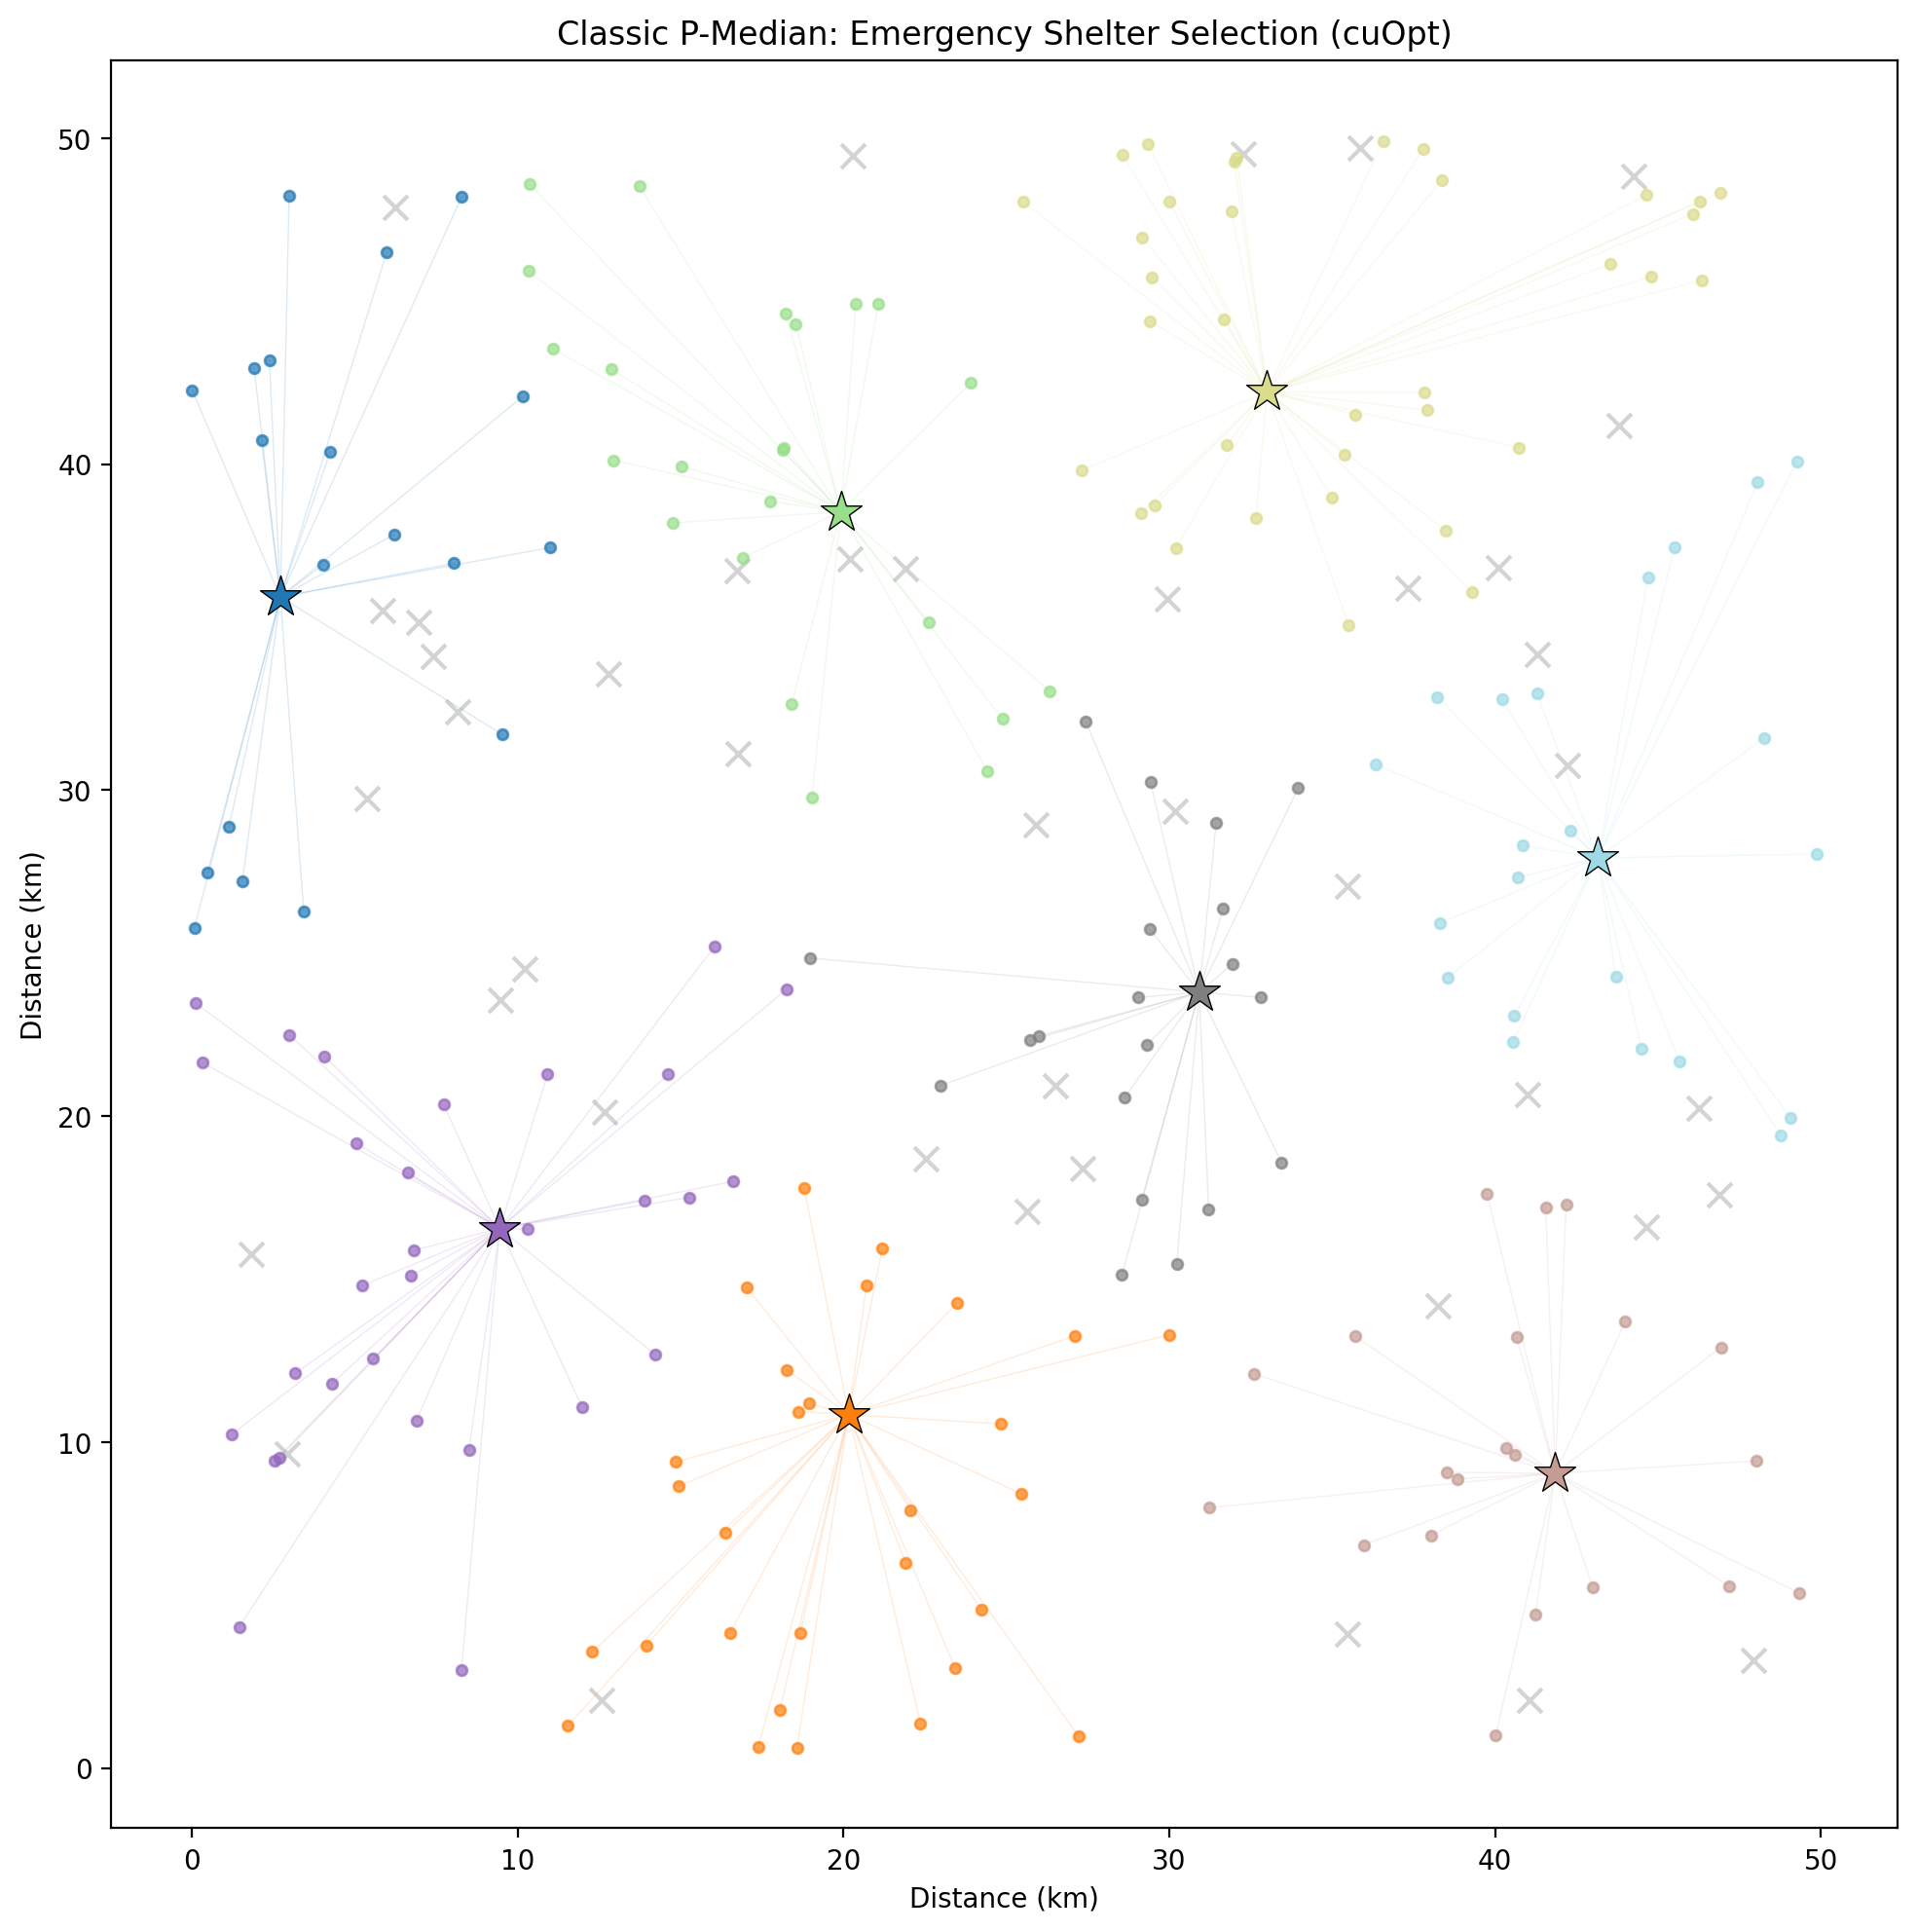

In [ ]:
model_classic, open_shelters, allocation = solve_pmedian_cuopt(
    cost_matrix, population_demand, p=P_SHELTERS, name="Classic_Emergency_Shelter"
)

print(f"\nEstablished Shelter Indices: {open_shelters}")

# Calculate mean weighted evacuation distance
total_cost = model_classic.ObjValue
mean_evac_dist = total_cost / population_demand.sum()
print(f"Mean evacuation distance per person: {mean_evac_dist:.2f} km")
print(f"Total population served: {population_demand.sum():,} people")

plot_solution(zone_coords, shelter_coords, open_shelters, allocation,
              title="Classic P-Median: Emergency Shelter Selection (cuOpt)")


## 2. Capacitated P-Median: Shelter Occupancy Limits

In reality, emergency shelters have **capacity limits**. Facilities can only accommodate a certain number of evacuees before becoming overcrowded. Fire safety codes, sanitation requirements, and available supplies all impose occupancy constraints. The capacitated variant adds:

$$\sum_{i \in I} a_i \cdot x_{ij} \leq C_j \cdot y_j \quad \forall j \in J$$

where $C_j$ is the maximum occupancy of shelter $j$.

**Emergency Response Interpretation**: In a metropolitan earthquake scenario with ~55,000 displaced people, we need **large-capacity regional facilities** as potential shelter sites:
- **Convention centers**: 5,000-10,000 people
- **Sports arenas/stadiums**: 4,000-8,000 people  
- **Fairgrounds/expo halls**: 3,000-6,000 people
- **Large school complexes**: 2,000-4,000 people

These represent the 50 pre-identified **mega-shelter sites** in the region. We must ensure no shelter exceeds safe occupancy, even if it means some evacuees travel to a more distant shelter.

This often results in a **higher objective value** than the uncapacitated case, representing the real-world trade-off between distance and capacity.


Total Shelter Capacity: 7,167 people
Total Population Demand: 1,157 people
Capacity/Demand Ratio: 6.19x
Problem exported to Capacitated_Emergency_Shelter.mps
Solve Status: Optimal
Objective Value: 7982.988

Shelter    Zones Served    Population      Capacity        Utilization 
-------------------------------------------------------------------
9          20              92        101        91.1%
10         19              137        176        77.8%
14         23              150        150        100.0%
24         24              129        187        69.0%
25         31              179        187        95.7%
28         34              186        186        100.0%
32         25              137        163        84.0%
43         24              147        147        100.0%


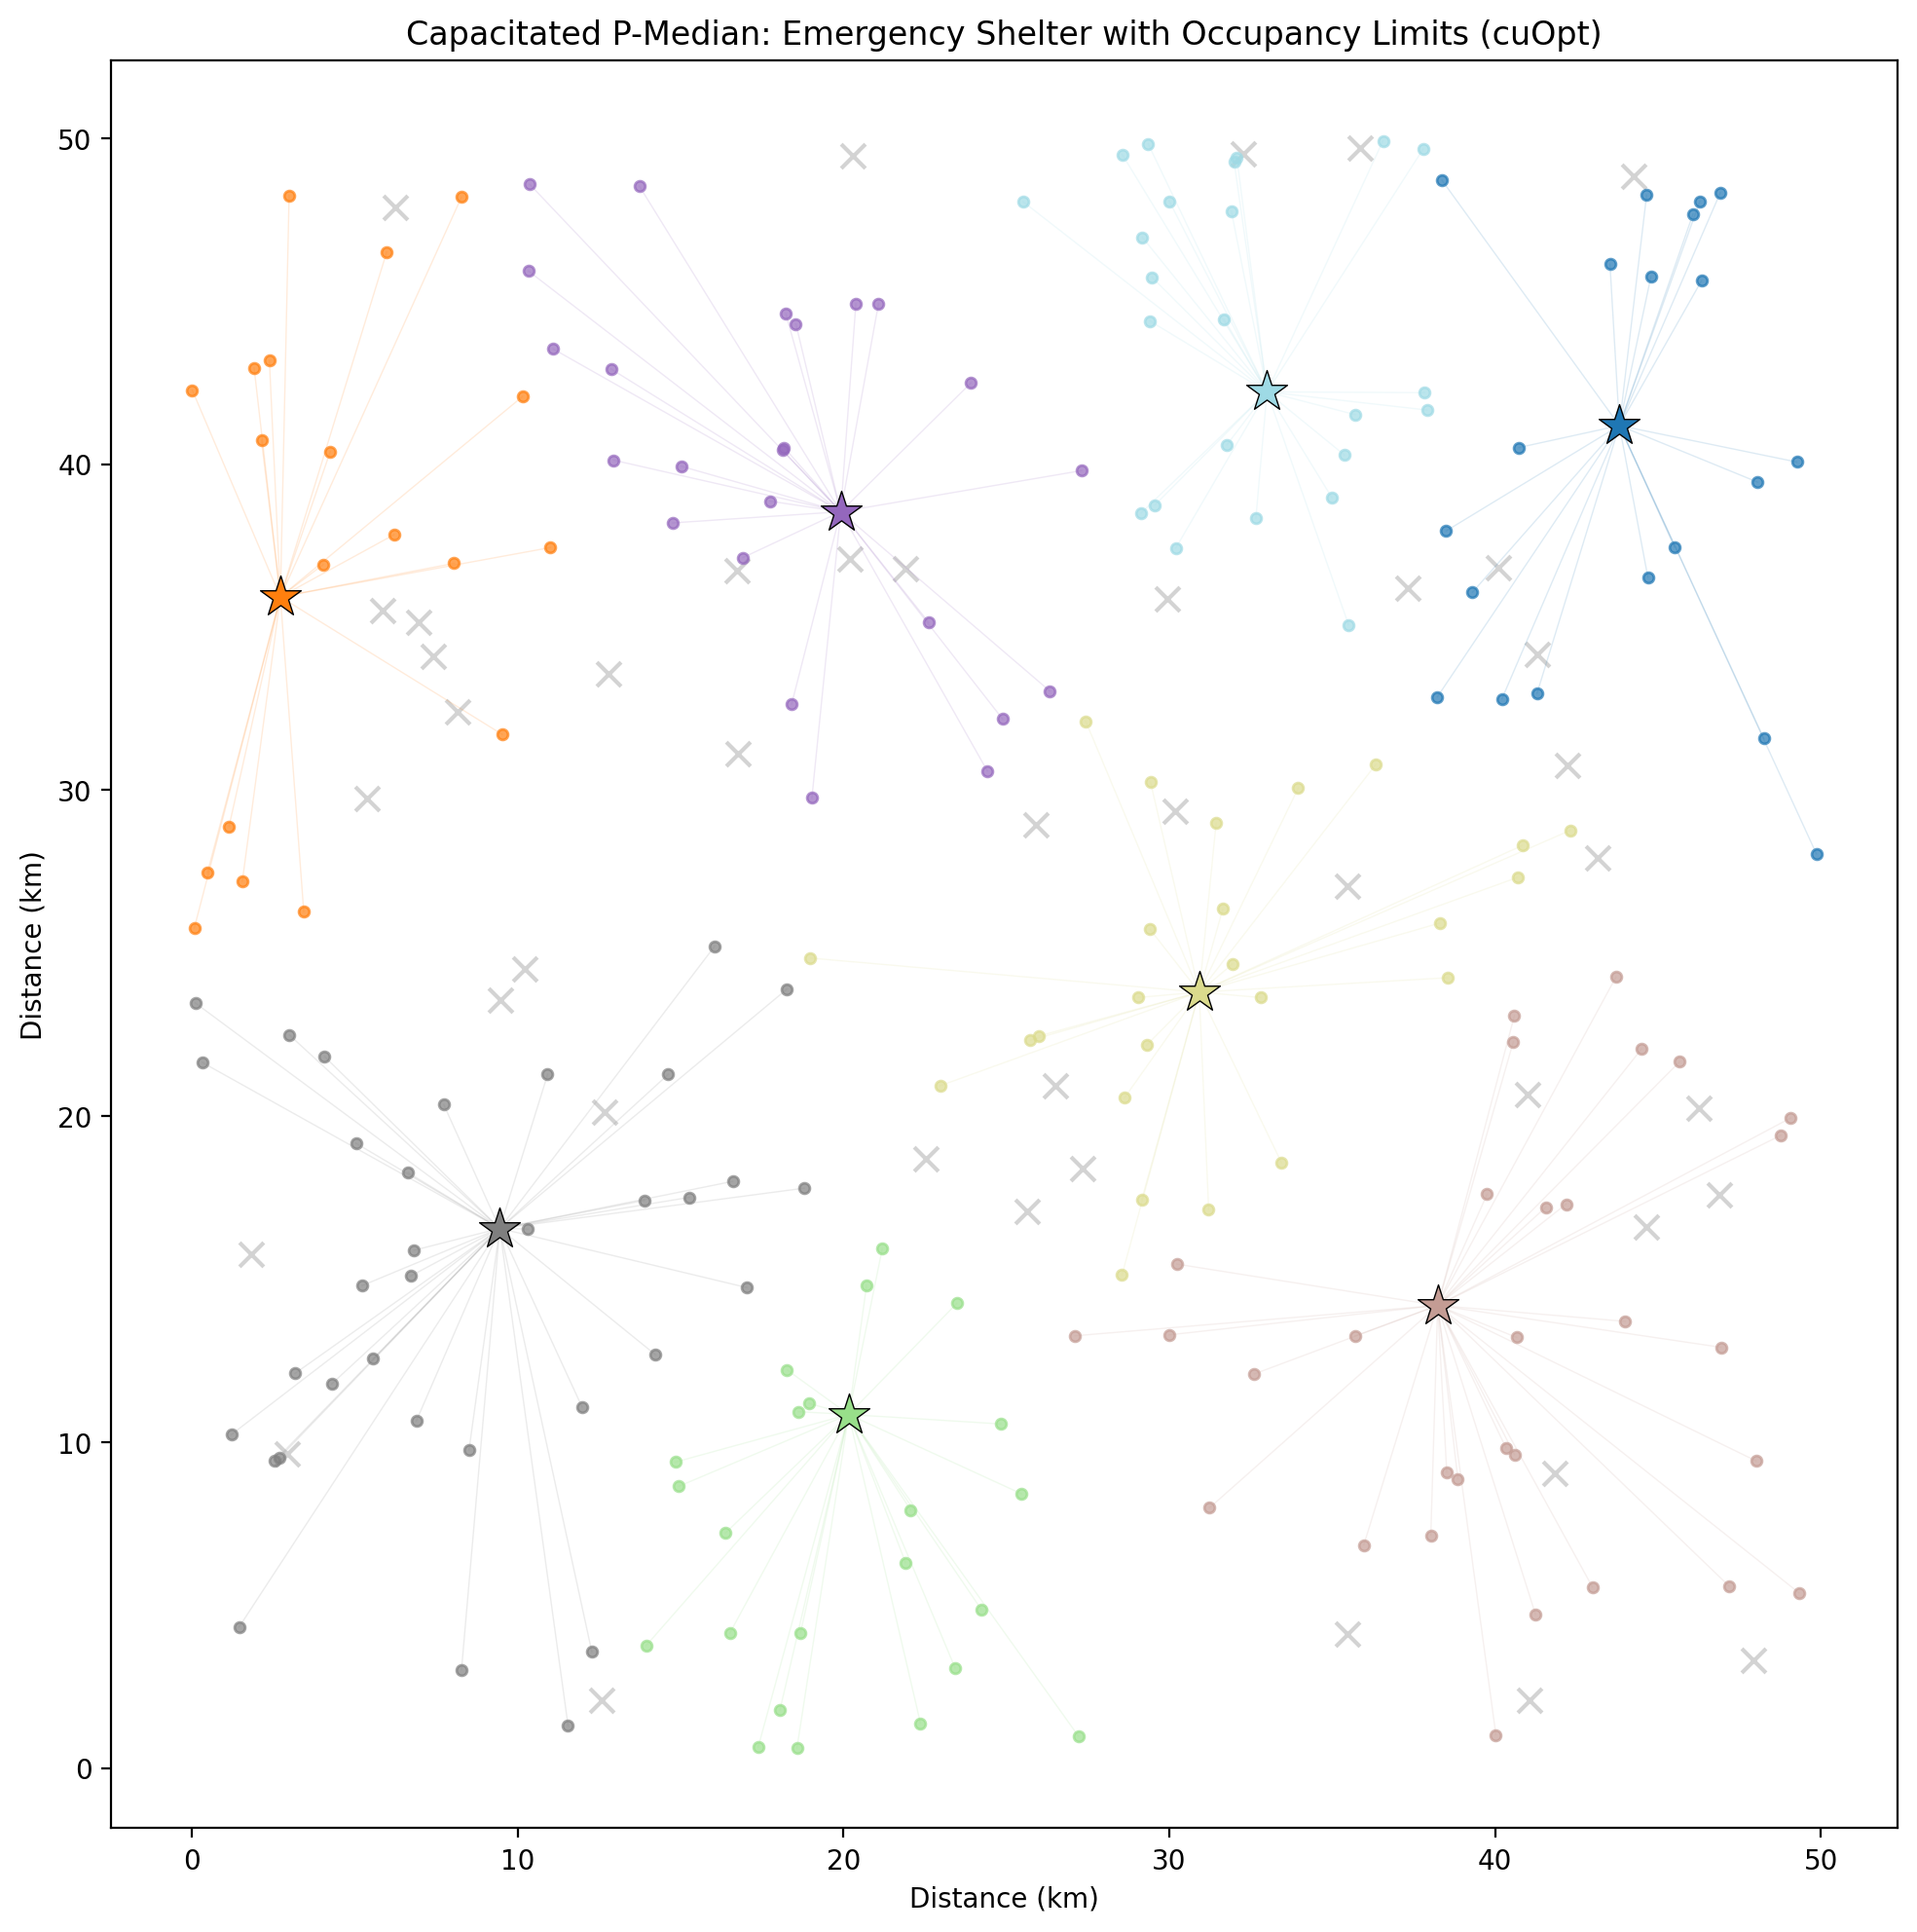

In [ ]:
# Generate shelter capacities for mega-shelter sites (convention centers, arenas, fairgrounds)
# Total capacity across all sites >> demand, but only 8 shelters will be selected
np.random.seed(1)
shelter_capacity = np.random.randint(100, 200, SHELTER_COUNT)

print(f"Total Shelter Capacity: {shelter_capacity.sum():,} people")
print(f"Total Population Demand: {population_demand.sum():,} people")
print(f"Capacity/Demand Ratio: {shelter_capacity.sum()/population_demand.sum():.2f}x")

model_cap, open_shelters_cap, allocation_cap = solve_pmedian_cuopt(
    cost_matrix, population_demand, p=P_SHELTERS,
    capacities=shelter_capacity, name="Capacitated_Emergency_Shelter"
)

# Display allocation details
if open_shelters_cap:
    print(f"\n{'Shelter':<10} {'Zones Served':<15} {'Population':<15} {'Capacity':<15} {'Utilization':<12}")
    print("-" * 67)
    for shelter_idx in open_shelters_cap:
        zone_count = len(allocation_cap[shelter_idx])
        pop_served = sum(population_demand[i] for i in allocation_cap[shelter_idx])
        utilization = pop_served / shelter_capacity[shelter_idx] * 100
        print(f"{shelter_idx:<10} {zone_count:<15} {pop_served:,}{'':<7} {shelter_capacity[shelter_idx]:,}{'':<7} {utilization:.1f}%")

    plot_solution(zone_coords, shelter_coords, open_shelters_cap, allocation_cap,
                  title="Capacitated P-Median: Emergency Shelter with Occupancy Limits (cuOpt)")


## 3. Capacitated P-Median with Preselected Shelters

Sometimes certain shelter locations **must** be included in the solution due to external constraints:
- **Existing emergency infrastructure**: Designated disaster shelters already set up with supplies
- **Government agreements**: Pre-negotiated contracts with schools or community centers
- **Strategic importance**: Locations critical for communication or coordination
- **Accessibility requirements**: ADA-compliant facilities for vulnerable populations

We model this by fixing $y_j = 1$ for predefined shelters:

$$y_j = 1 \quad \forall j \in J_{predefined}$$

**Emergency Response Interpretation**: The city has two designated emergency shelters (locations 0 and 1) that were established before the disaster with pre-positioned supplies, medical equipment, and trained staff. These must be used regardless of whether they're mathematically optimal. The agency selects the remaining 6 shelters to minimize overall evacuation distance.


Problem exported to Predefined_Emergency_Shelter.mps
Solve Status: Optimal
Objective Value: 8552.286

Shelter    Status          Zones      Population      Capacity        Util %    
---------------------------------------------------------------------------
0          [PREDEFINED]    16         93        137        67.9%
1          [PREDEFINED]    13         77        112        68.8%
10         Selected        21         142        176        80.7%
11         Selected        32         171        171        100.0%
14         Selected        24         149        150        99.3%
24         Selected        33         187        187        100.0%
28         Selected        32         176        186        94.6%
32         Selected        29         162        163        99.4%


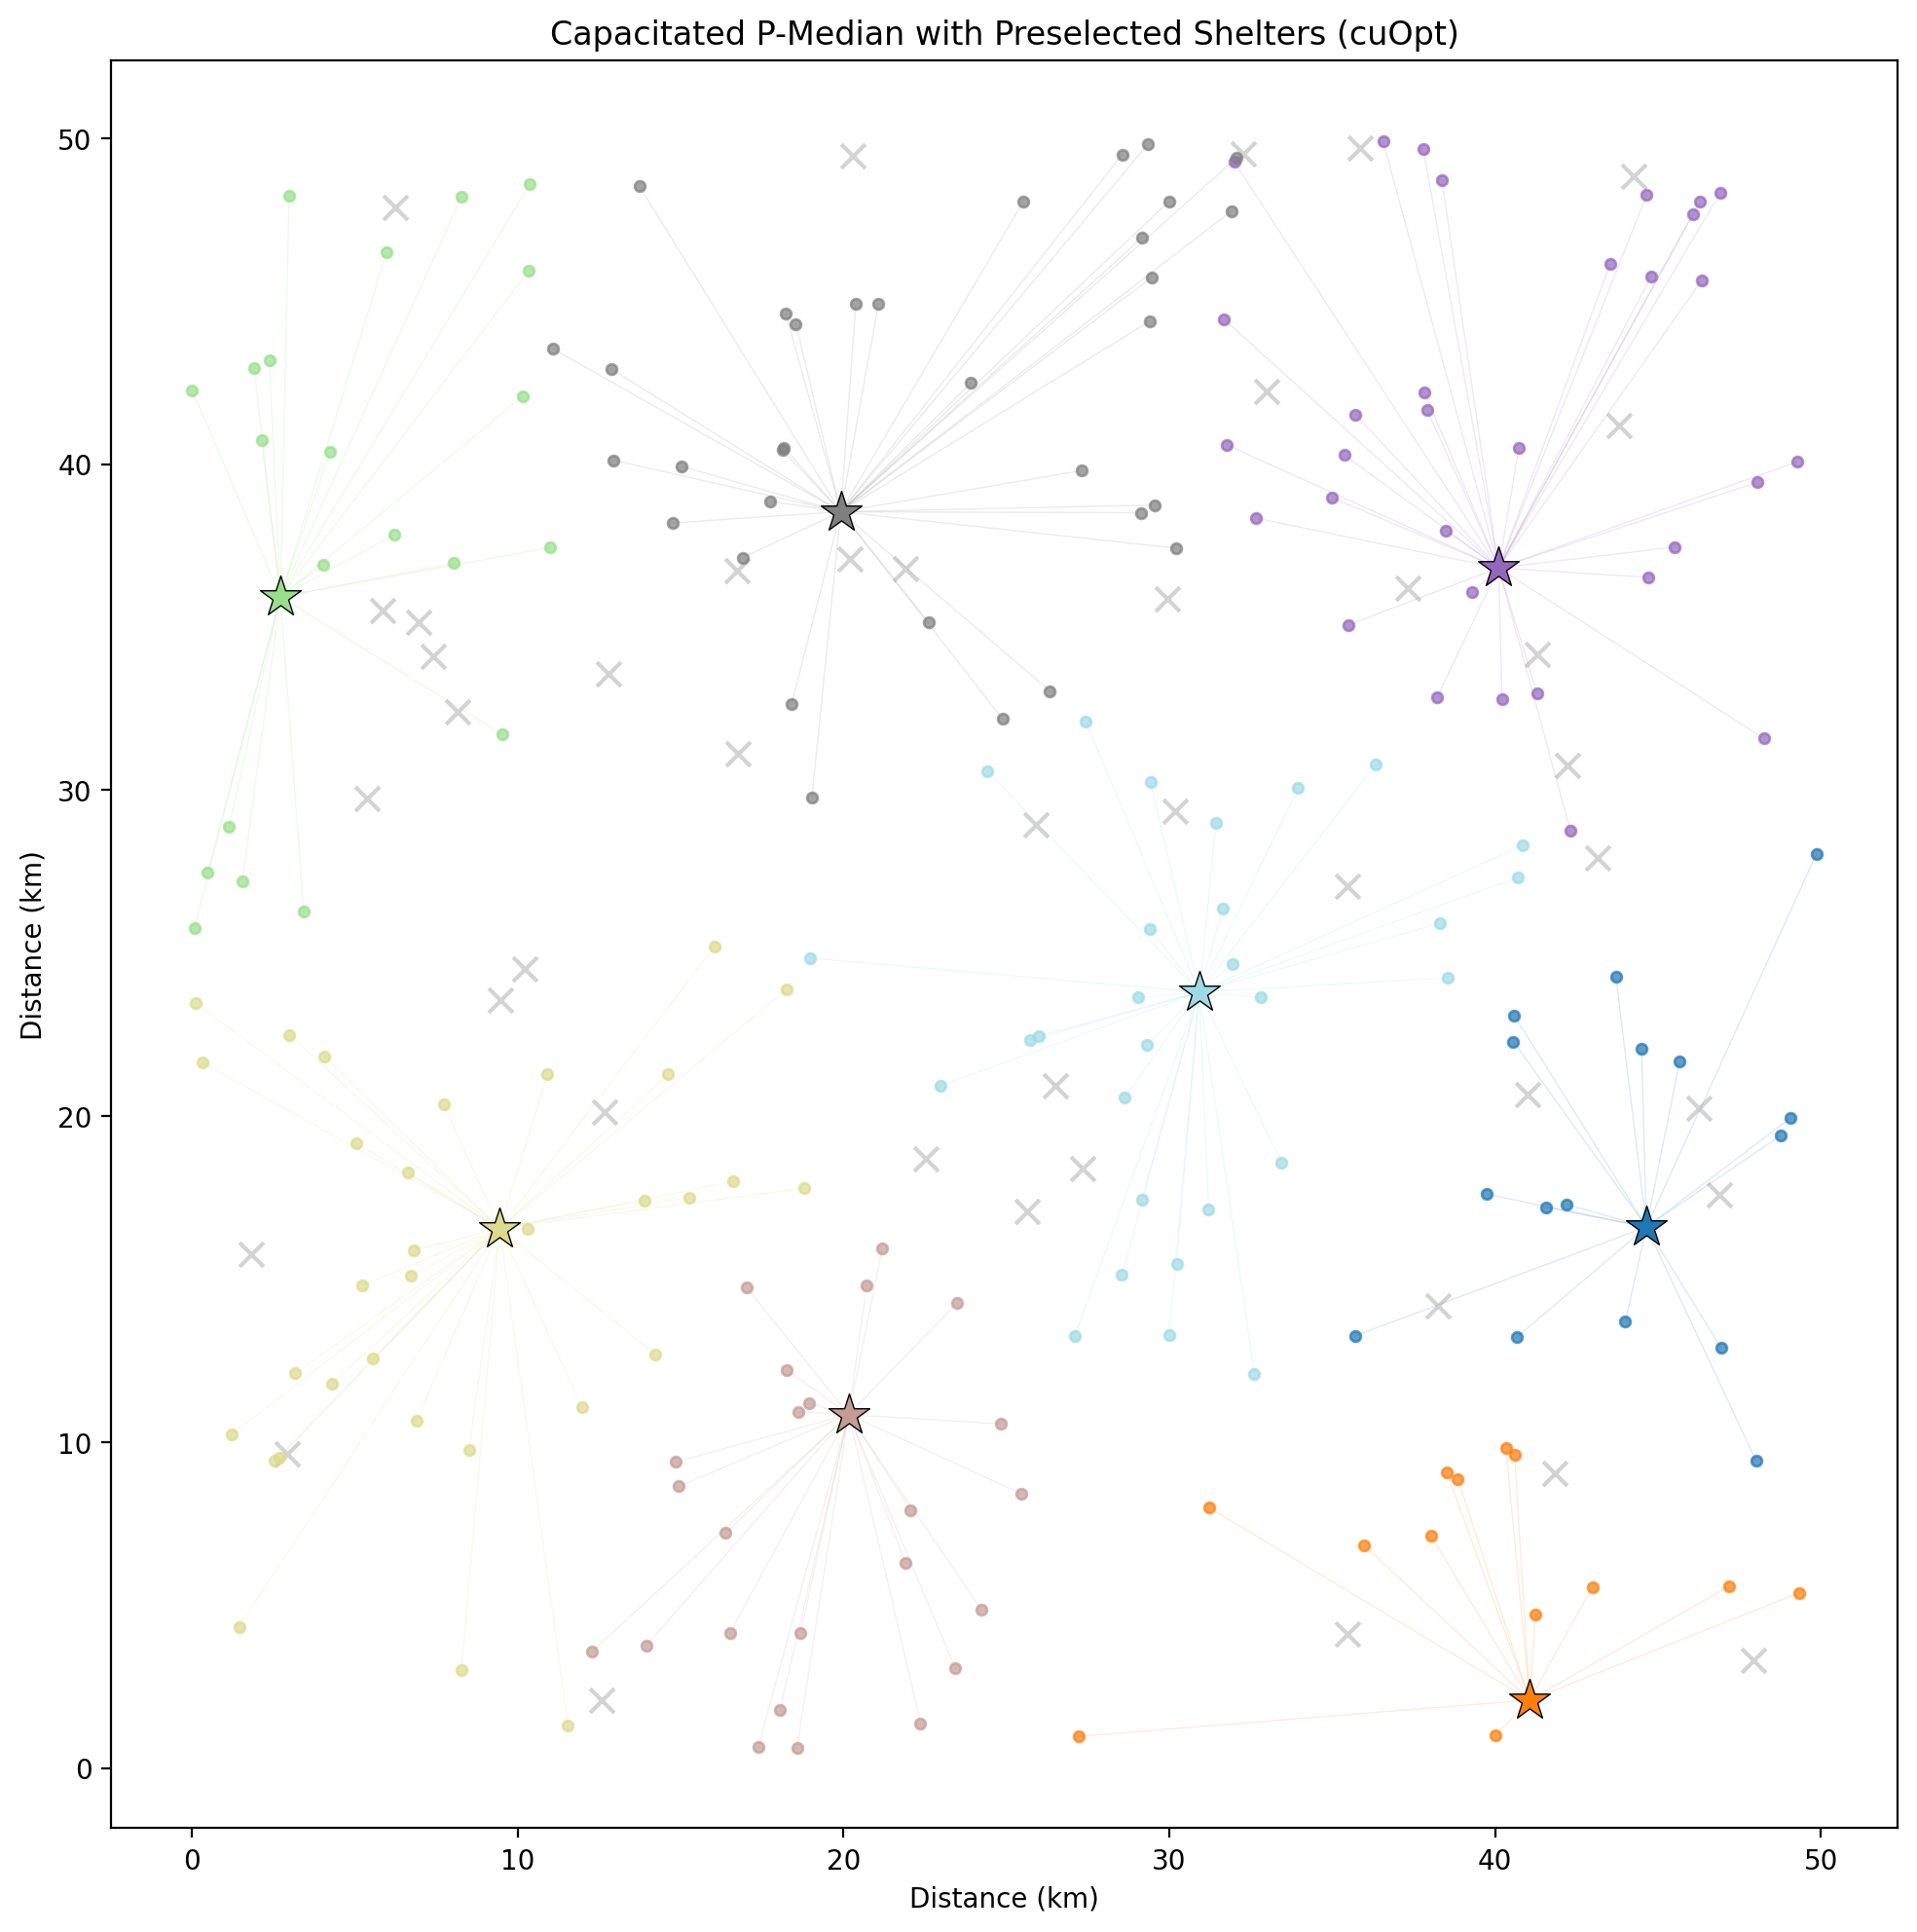

In [ ]:
# Predefined shelters: existing emergency infrastructure at locations 0 and 1
predefined_shelters = np.array([0, 1])

model_pre, open_shelters_pre, allocation_pre = solve_pmedian_cuopt(
    cost_matrix, population_demand, p=P_SHELTERS,
    capacities=shelter_capacity,
    predefined_indices=predefined_shelters,
    name="Predefined_Emergency_Shelter"
)

if open_shelters_pre:
    print(f"\n{'Shelter':<10} {'Status':<15} {'Zones':<10} {'Population':<15} {'Capacity':<15} {'Util %':<10}")
    print("-" * 75)
    for shelter_idx in open_shelters_pre:
        zone_count = len(allocation_pre[shelter_idx])
        pop_served = sum(population_demand[i] for i in allocation_pre[shelter_idx])
        utilization = pop_served / shelter_capacity[shelter_idx] * 100
        status = "[PREDEFINED]" if shelter_idx in predefined_shelters else "Selected"
        print(f"{shelter_idx:<10} {status:<15} {zone_count:<10} {pop_served:,}{'':<7} {shelter_capacity[shelter_idx]:,}{'':<7} {utilization:.1f}%")

    plot_solution(zone_coords, shelter_coords, open_shelters_pre, allocation_pre,
                  title="Capacitated P-Median with Preselected Shelters (cuOpt)")


## 4. Capacitated P-Median with 'Fulfill Capacity' Mandate

A more restrictive variant where predefined shelters must operate at **exactly** their capacity (equality instead of inequality):

$$\sum_{i \in I} a_i \cdot x_{ij} = C_j \quad \forall j \in J_{predefined}$$

**Emergency Response Interpretation**: The city's designated emergency shelters at locations 0 and 1 have received federal funding based on their stated capacity. Government regulations require that these shelters be **fully utilized** before additional shelters can request resources. This ensures:
- Efficient use of pre-positioned supplies
- Accountability for federal disaster relief funds
- Maximum utilization of trained personnel at these sites

This is the **most constrained scenario** and typically produces the highest objective value. Some evacuees may travel further to ensure the predefined shelters reach exactly their target capacity.


Problem exported to Fulfill_Emergency_Shelter.mps
Solve Status: Optimal
Objective Value: 8814.721

Shelter    Status             Zones      Population   Capacity     Match     
------------------------------------------------------------------------
0          [MUST FULFILL]     27         137     137     ✓ EXACT   
1          [MUST FULFILL]     16         112     112     ✓ EXACT   
7          Selected           28         164     164     -         
10         Selected           19         137     176     -         
14         Selected           23         150     150     -         
24         Selected           29         158     187     -         
28         Selected           32         168     186     -         
32         Selected           26         131     163     -         


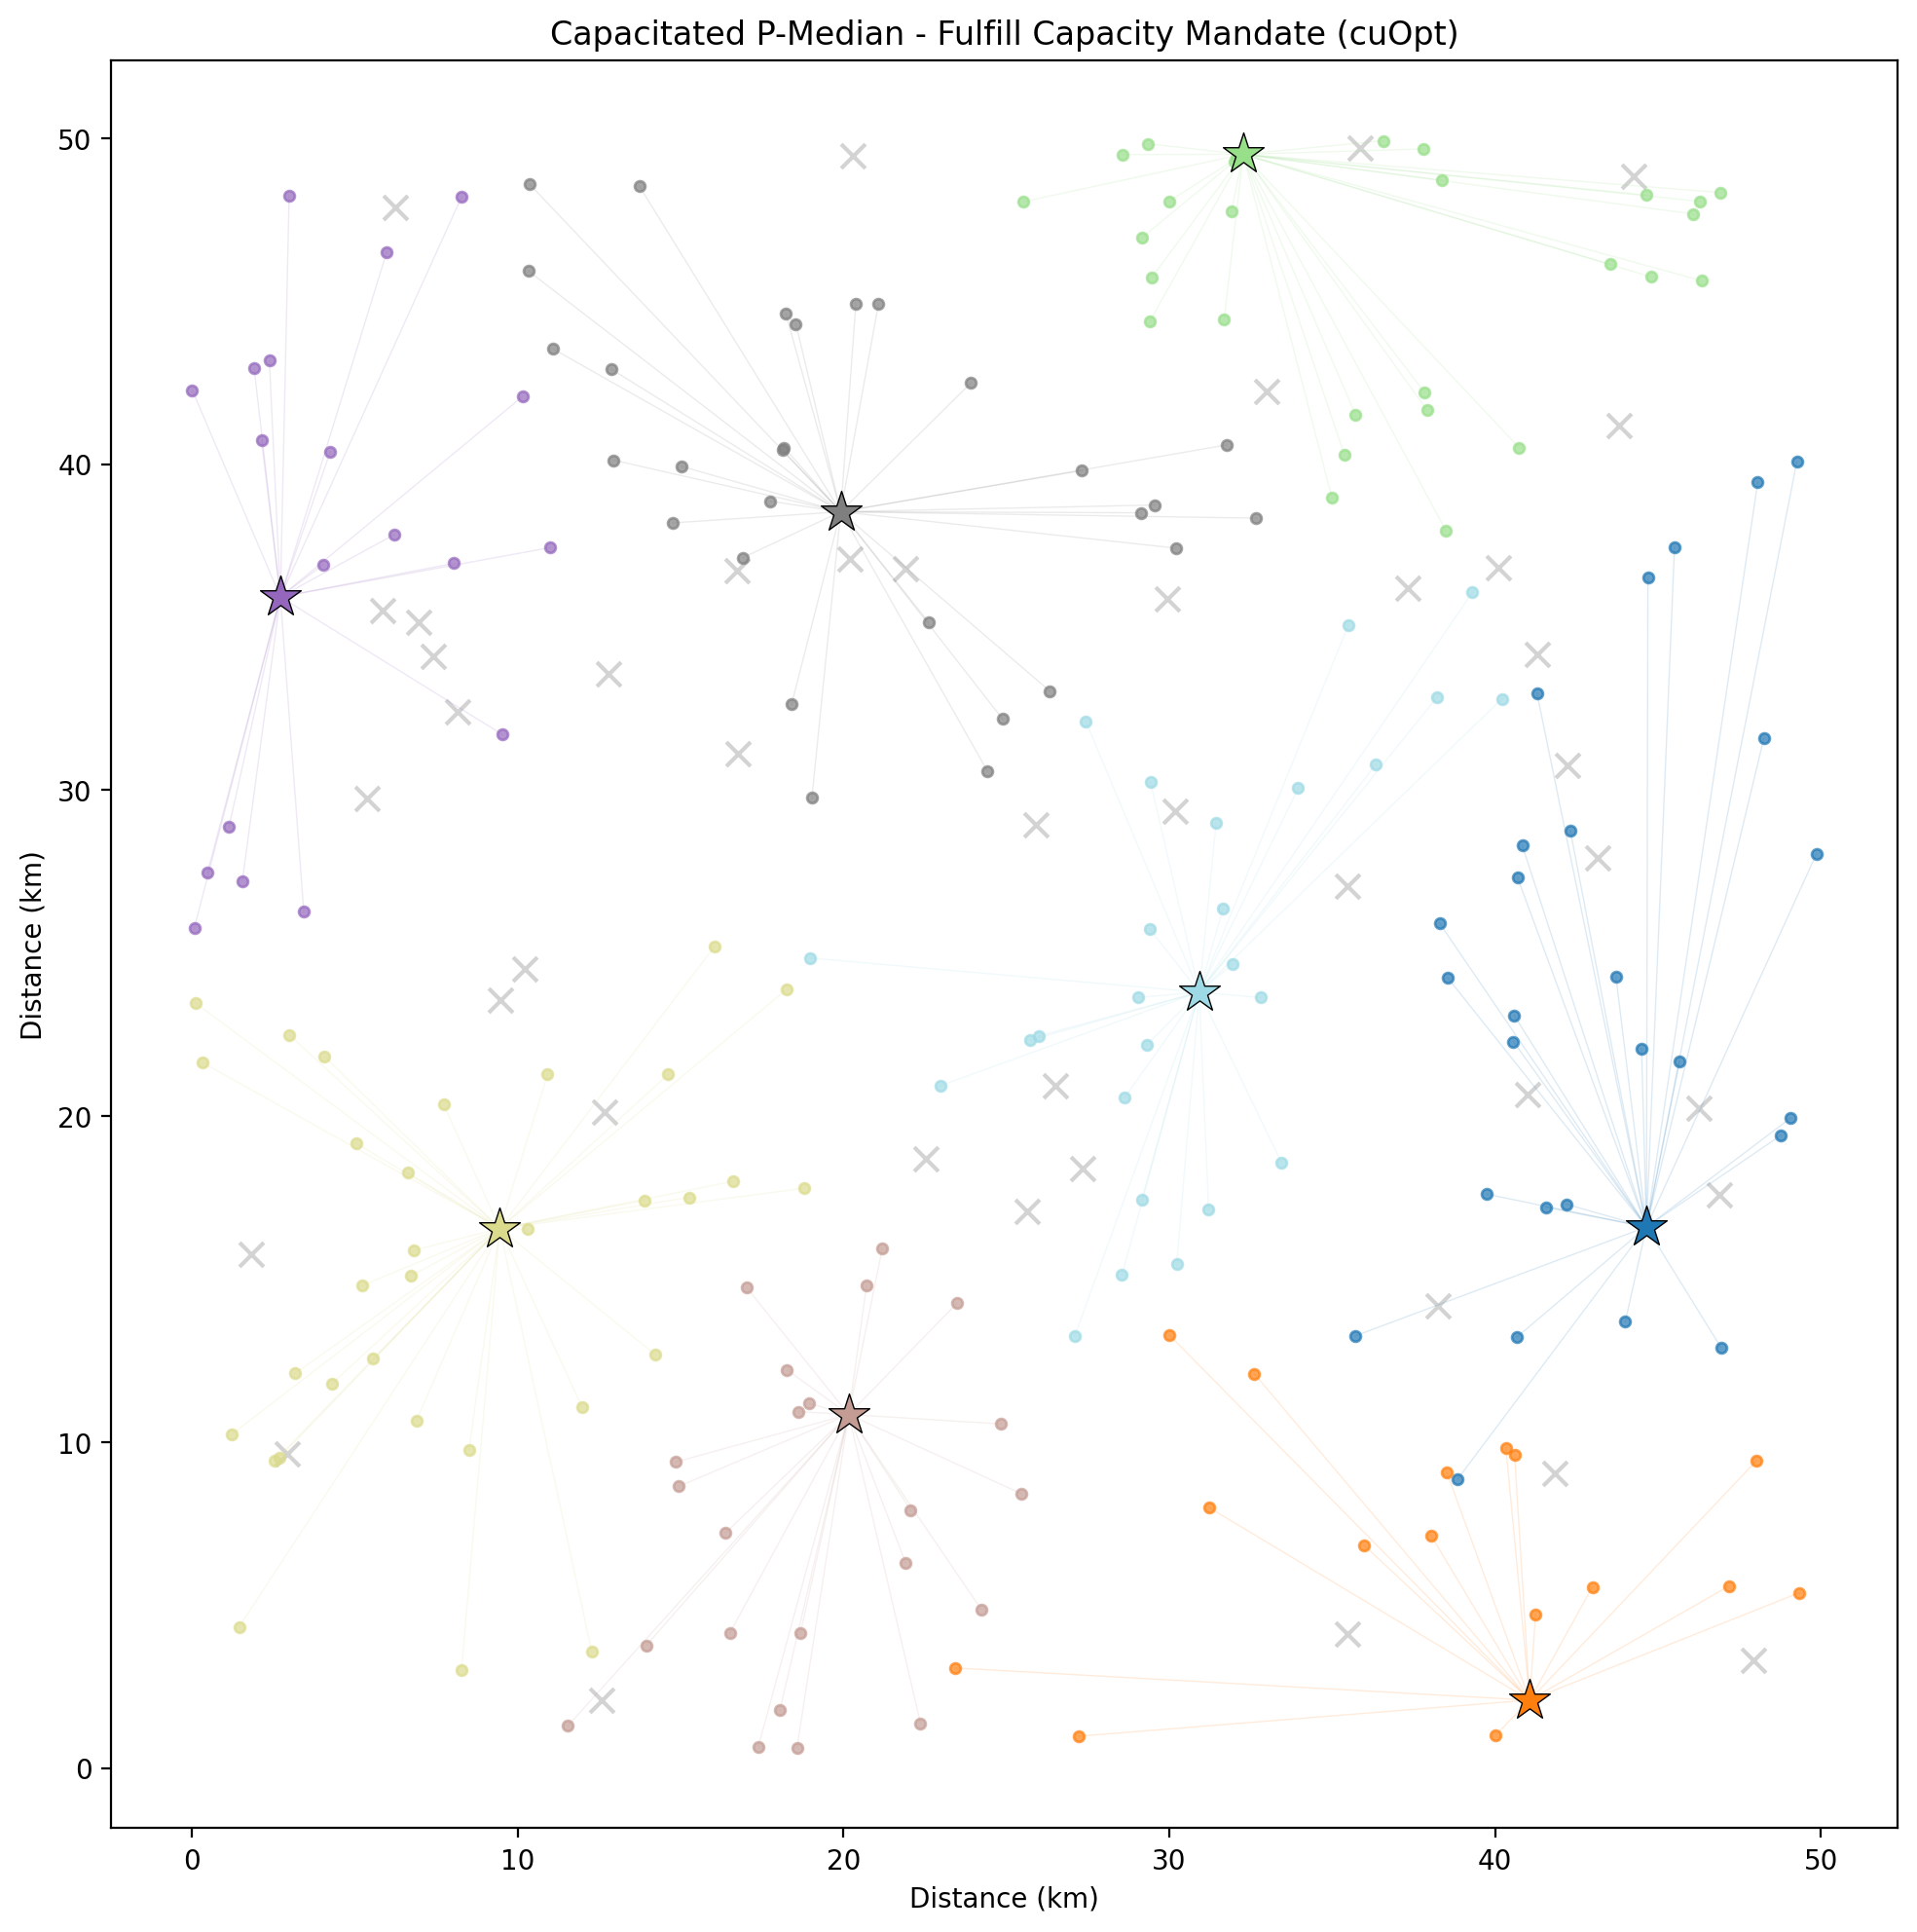

In [ ]:
model_fulfill, open_shelters_full, allocation_full = solve_pmedian_cuopt(
    cost_matrix, population_demand, p=P_SHELTERS,
    capacities=shelter_capacity,
    predefined_indices=predefined_shelters,
    fulfill_predefined=True,
    name="Fulfill_Emergency_Shelter"
)

if open_shelters_full:
    print(f"\n{'Shelter':<10} {'Status':<18} {'Zones':<10} {'Population':<12} {'Capacity':<12} {'Match':<10}")
    print("-" * 72)
    for shelter_idx in open_shelters_full:
        pop_served = sum(population_demand[i] for i in allocation_full[shelter_idx])
        zone_count = len(allocation_full[shelter_idx])

        if shelter_idx in predefined_shelters:
            status = "[MUST FULFILL]"
            match = "✓ EXACT" if pop_served == shelter_capacity[shelter_idx] else f"Δ {pop_served - shelter_capacity[shelter_idx]}"
        else:
            status = "Selected"
            match = "-"

        print(f"{shelter_idx:<10} {status:<18} {zone_count:<10} {pop_served:,}{'':<4} {shelter_capacity[shelter_idx]:,}{'':<4} {match:<10}")

    plot_solution(zone_coords, shelter_coords, open_shelters_full, allocation_full,
                  title="Capacitated P-Median - Fulfill Capacity Mandate (cuOpt)")


## Summary: Comparing Emergency Response Variants (Small-Scale)

Let's compare the objective values across the four variants to understand the impact of adding real-world constraints:


In [ ]:
# Compare objective values across variants
print("=" * 70)
print("COMPARISON: Impact of Constraints on Total Evacuation Distance")
print("=" * 70)

variants = [
    ("1. Classic (No Constraints)", model_classic),
    ("2. Capacitated (Occupancy Limits)", model_cap),
    ("3. Predefined + Capacitated", model_pre),
    ("4. Fulfill Capacity Mandate", model_fulfill),
]

baseline = model_classic.ObjValue

print(f"\n{'Variant':<40} {'Objective':>15} {'vs Baseline':>15}")
print("-" * 70)

for name, model in variants:
    if model is not None:
        obj = model.ObjValue
        pct_increase = ((obj - baseline) / baseline) * 100
        pct_str = f"+{pct_increase:.1f}%" if pct_increase > 0 else "baseline"
        print(f"{name:<40} {obj:>15,.0f} {pct_str:>15}")

print("-" * 70)
print(f"\n📊 Key Insight: Adding real-world constraints increases total evacuation")
print(f"   distance, but ensures feasibility, safety, and regulatory compliance.")
print(f"\n   The {((model_fulfill.ObjValue - baseline) / baseline * 100):.1f}% increase from baseline to fulfill-capacity")
print(f"   represents the 'cost of compliance' with federal shelter mandates.")


COMPARISON: Impact of Constraints on Total Evacuation Distance

Variant                                        Objective     vs Baseline
----------------------------------------------------------------------
1. Classic (No Constraints)                        7,709        baseline
2. Capacitated (Occupancy Limits)                  7,983           +3.6%
3. Predefined + Capacitated                        8,552          +10.9%
4. Fulfill Capacity Mandate                        8,815          +14.3%
----------------------------------------------------------------------

📊 Key Insight: Adding real-world constraints increases total evacuation
   distance, but ensures feasibility, safety, and regulatory compliance.

   The 14.3% increase from baseline to fulfill-capacity
   represents the 'cost of compliance' with federal shelter mandates.


---

## Scaling Up: From City to Region

The above examples demonstrated P-Median variants on a manageable problem size (200 zones, 50 shelter sites). But what happens when disaster strikes at a larger scale?

The next section tests cuOpt's ability to handle **regional-scale disasters** where problem complexity grows significantly.


# Part II: Large-Scale Regional Emergency Response

## 5. Catastrophic Disaster Scenario (with Timeout)

Real-world disaster scenarios are often much larger in scale. Consider a **catastrophic regional earthquake** affecting an entire metropolitan area:
- **800 affected zones** (neighborhoods, districts, communities) with ~1 million displaced people
- **120 candidate mega-shelter sites** (major stadiums, convention centers, state fairgrounds, military bases)
- **25 shelters** to establish (based on available emergency personnel, National Guard deployment, and supplies)

Each mega-shelter can accommodate 20,000-50,000 people—similar to real-world examples like the Houston Astrodome (25,000 Katrina evacuees) or the New Orleans Convention Center.

This creates a MIP with **~100,000 binary variables** ($x_{ij}$) and **~100,000 constraints**. cuOpt's GPU acceleration is essential for solving such large problems efficiently—critical when every minute counts in disaster response.

**Practical Consideration**: In emergency situations, we often cannot wait for a provably optimal solution. Setting a **time limit** allows us to get a good solution quickly:
- cuOpt returns the **best feasible solution** found within the time budget
- The **MIP gap** indicates how close we are to the theoretical optimum
- Decision-makers can start mobilizing resources with a near-optimal plan while refinement continues


=== Large-Scale Disaster Scenario ===
Total population requiring shelter: 21,864 people
Total shelter capacity available: 87,408 people
Cost matrix shape: (800, 120)
Number of binary decision variables: ~96,120
Number of constraints: ~96,921
Problem exported to Large_Scale_Emergency_Response.mps
Solve Status: FeasibleFound
Objective Value: 135206.384

=== Solution Summary ===
Established 25 emergency shelters:
  Shelter   9:   36 zones,     927 people ( 99.9% capacity)
  Shelter  12:   41 zones,     927 people ( 98.6% capacity)
  Shelter  15:   32 zones,     865 people ( 99.4% capacity)
  Shelter  21:   30 zones,     881 people ( 99.9% capacity)
  Shelter  22:   35 zones,     923 people ( 97.4% capacity)
  Shelter  23:   34 zones,     873 people ( 99.8% capacity)
  Shelter  26:   34 zones,     876 people ( 98.1% capacity)
  Shelter  27:   34 zones,     875 people ( 99.7% capacity)
  Shelter  31:   35 zones,     950 people ( 99.9% capacity)
  Shelter  33:   33 zones,     953 people ( 99

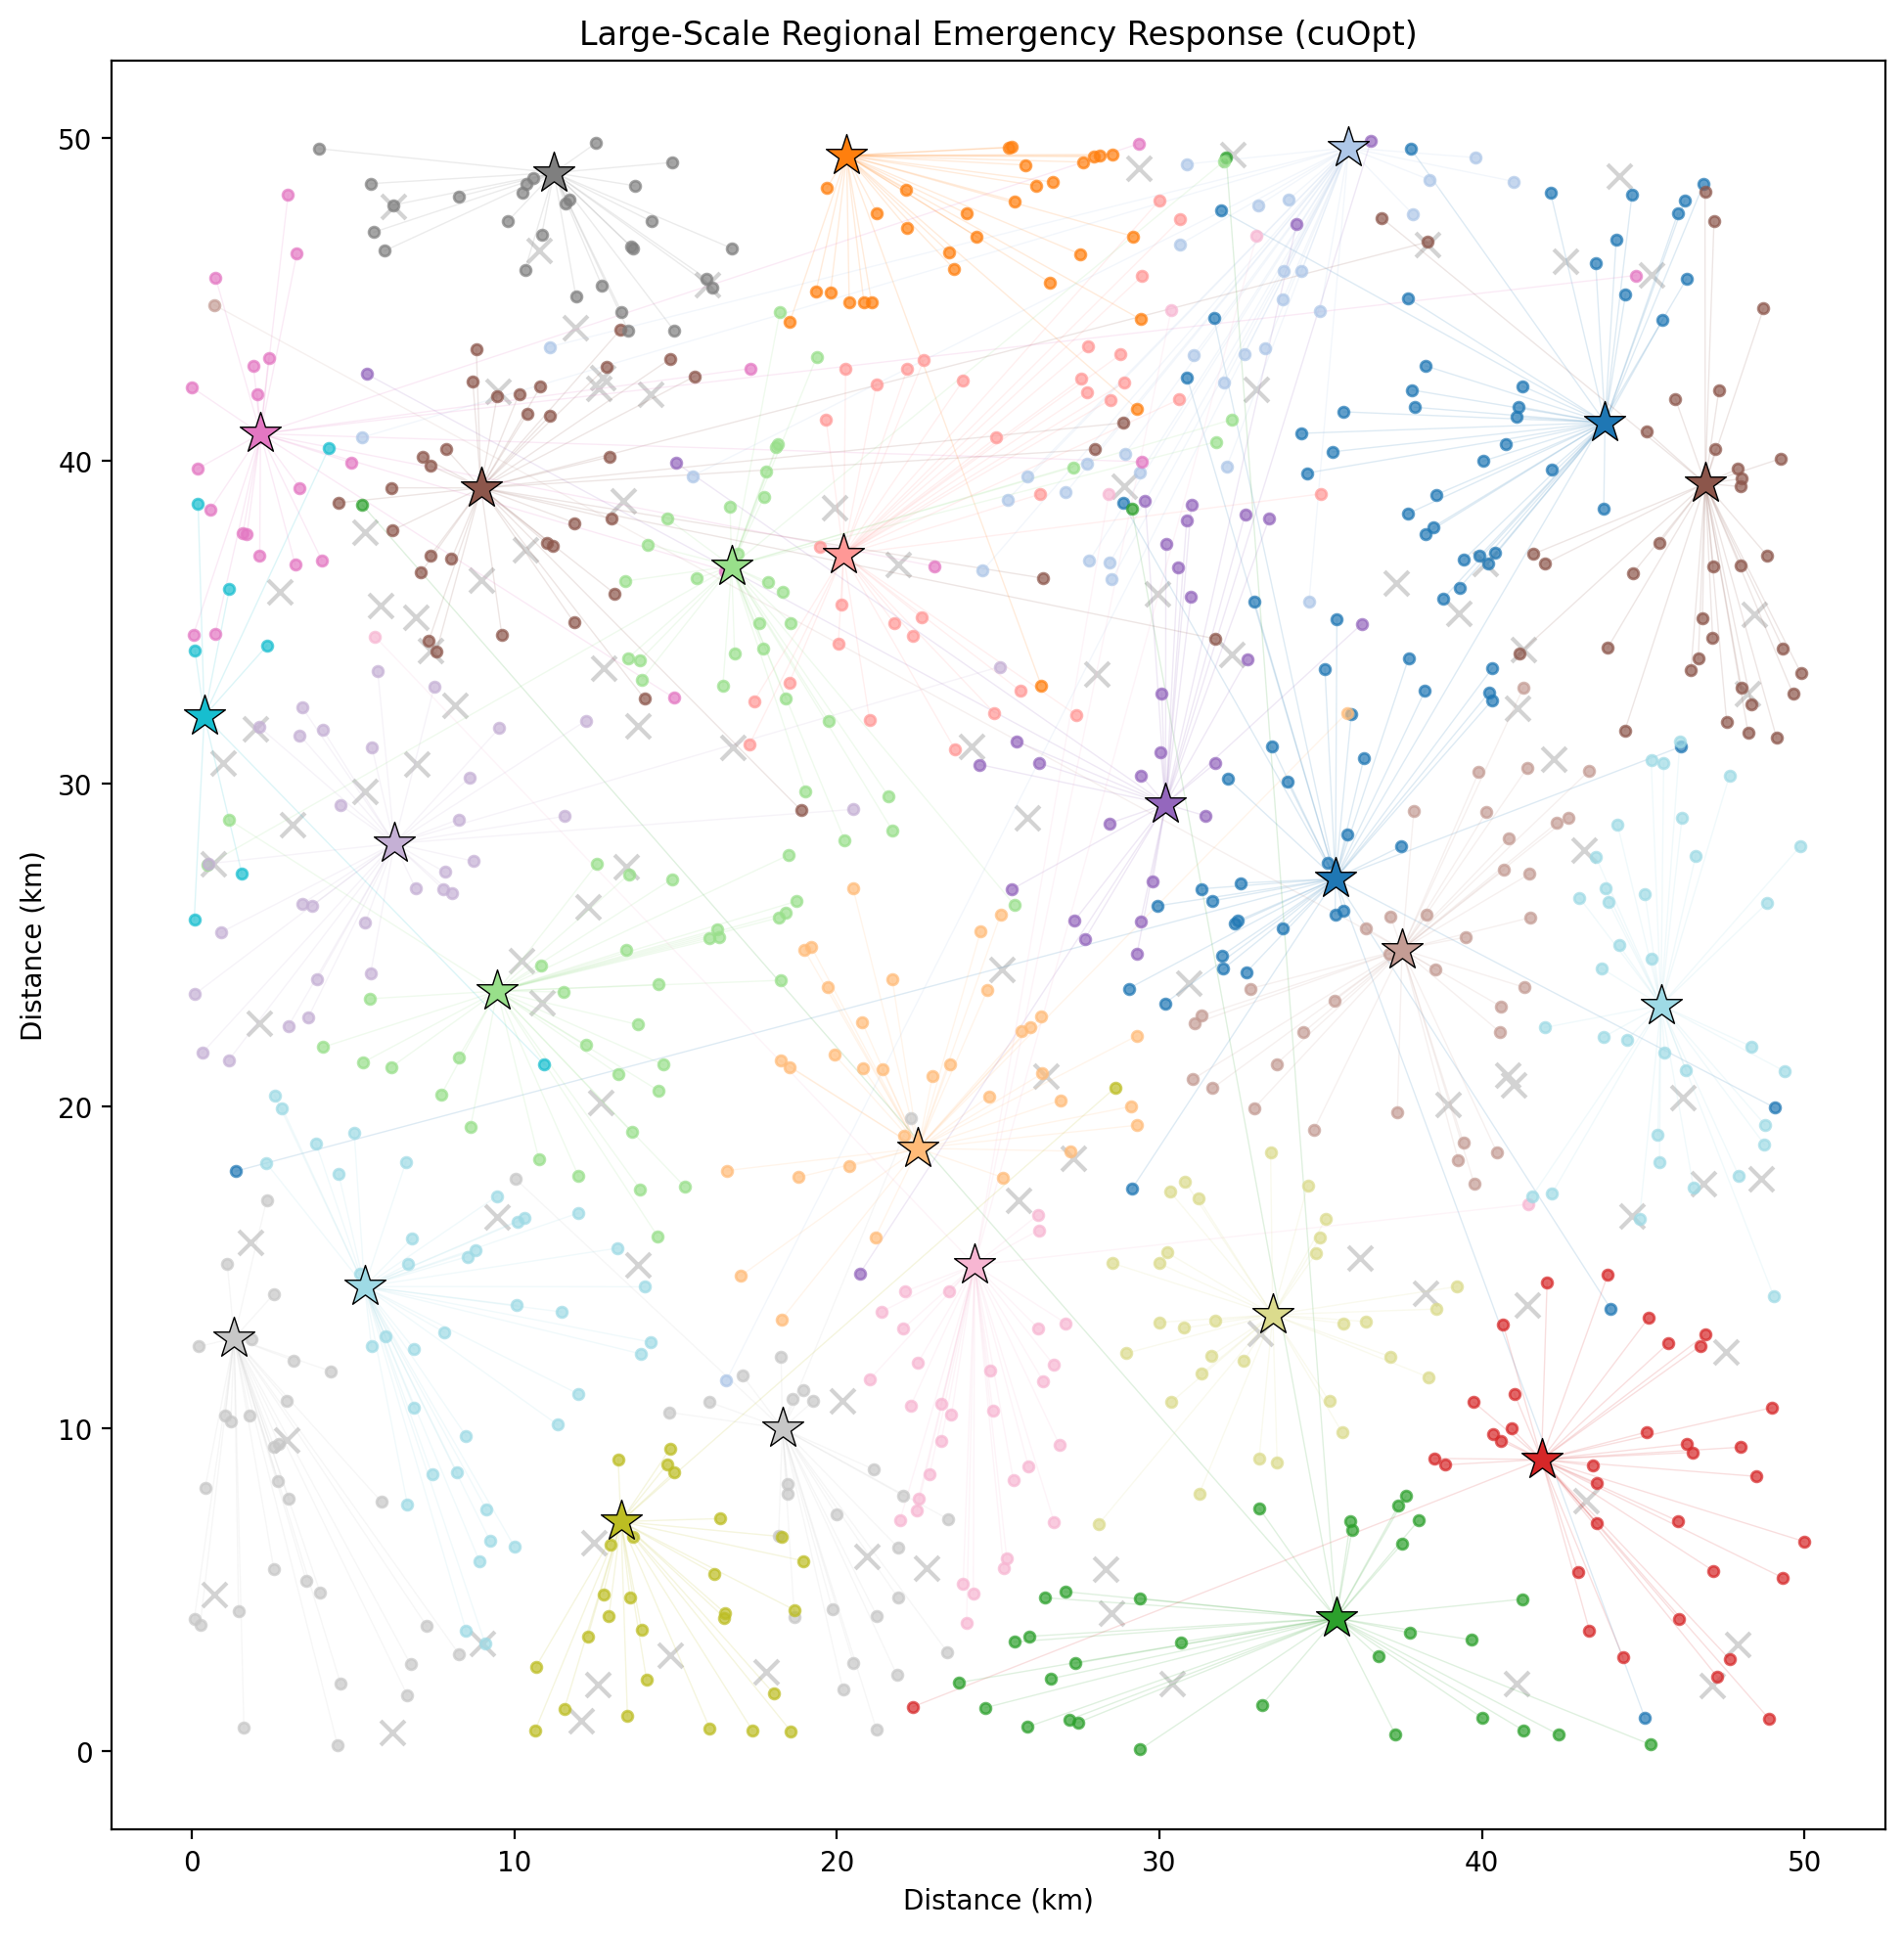

In [ ]:
# Large-scale disaster scenario parameters
LARGE_ZONE_COUNT = 800        # Affected population zones
LARGE_SHELTER_COUNT = 120      # Candidate shelter locations
LARGE_P_SHELTERS = 25          # Shelters to establish

# Generate large-scale disaster zone data
np.random.seed(ZONE_SEED)
large_zone_coords = np.random.rand(LARGE_ZONE_COUNT, 2) * COORD_RANGE

np.random.seed(SHELTER_SEED)
large_shelter_coords = np.random.rand(LARGE_SHELTER_COUNT, 2) * COORD_RANGE

large_population_demand = np.random.randint(1, 55, LARGE_ZONE_COUNT)

# Calculate evacuation distance matrix
large_cost_matrix = cdist(large_zone_coords, large_shelter_coords)

# Generate shelter capacities for regional mega-shelters
np.random.seed(1)
large_shelter_capacity = np.random.randint(0.6 * LARGE_ZONE_COUNT, 1.2 * LARGE_ZONE_COUNT, LARGE_SHELTER_COUNT)

print(f"=== Large-Scale Disaster Scenario ===")
print(f"Total population requiring shelter: {large_population_demand.sum():,} people")
print(f"Total shelter capacity available: {large_shelter_capacity.sum():,} people")
print(f"Cost matrix shape: {large_cost_matrix.shape}")
print(f"Number of binary decision variables: ~{LARGE_ZONE_COUNT * LARGE_SHELTER_COUNT + LARGE_SHELTER_COUNT:,}")
print(f"Number of constraints: ~{LARGE_ZONE_COUNT + 1 + LARGE_ZONE_COUNT * LARGE_SHELTER_COUNT + LARGE_SHELTER_COUNT:,}")

# Solve with 60-second timeout (simulating time-critical decision making)
model_large, open_shelters_large, allocation_large = solve_pmedian_cuopt(
    large_cost_matrix, large_population_demand, p=LARGE_P_SHELTERS,
    capacities=large_shelter_capacity,
    name="Large_Scale_Emergency_Response",
    time_limit=60
)

if open_shelters_large:
    print(f"\n=== Solution Summary ===")
    print(f"Established {len(open_shelters_large)} emergency shelters:")

    total_served = 0
    for shelter_idx in open_shelters_large:
        zone_count = len(allocation_large[shelter_idx])
        pop_served = sum(large_population_demand[i] for i in allocation_large[shelter_idx])
        total_served += pop_served
        utilization = pop_served / large_shelter_capacity[shelter_idx] * 100
        print(f"  Shelter {shelter_idx:3d}: {zone_count:4d} zones, {pop_served:7,} people ({utilization:5.1f}% capacity)")

    print(f"\nTotal population served: {total_served:,} people")

    plot_solution(large_zone_coords, large_shelter_coords, open_shelters_large, allocation_large,
                  title="Large-Scale Regional Emergency Response (cuOpt)")


## cuOpt API Summary

This notebook demonstrated the key features of cuOpt's Python MIP interface applied to emergency response optimization:

### Creating and Solving Problems

```python
from cuopt.linear_programming.problem import Problem, VType, sense
from cuopt.linear_programming.solver_settings import SolverSettings

# Create problem
problem = Problem("emergency_shelter")

# Add variables (binary = VType.INTEGER with bounds [0,1])
y = problem.addVariable(lb=0, ub=1, vtype=VType.INTEGER, name="shelter_open")
x = problem.addVariable(lb=0, ub=1, vtype=VType.INTEGER, name="assignment")

# Set objective (supports +, -, * with scalars)
problem.setObjective(population * distance * x, sense=sense.MINIMIZE)

# Add constraints (supports <=, >=, ==)
problem.addConstraint(x + y <= capacity, name="occupancy_limit")

# Configure solver for time-critical scenarios
settings = SolverSettings()
settings.set_parameter("time_limit", "60.0")  # Note: string value required

# Solve and extract results
problem.solve(settings)
print(f"Status: {problem.Status.name}")
print(f"Objective: {problem.ObjValue}")
print(f"Shelter open: {y.getValue()}")
```

### Key Advantages of cuOpt for Emergency Response

1. **GPU Acceleration**: Fast solving enables rapid decision-making during crises
2. **Intuitive API**: Emergency planners can focus on the problem, not the solver syntax
3. **Time Limits**: Get good solutions quickly when every minute counts
4. **MPS Support**: Export problems for documentation and reproducibility
5. **Scalability**: Handle large metropolitan-scale disasters efficiently

## Conclusion & Extensions

This notebook demonstrated the P-Median problem applied to emergency response and disaster relief scenarios using cuOpt's MIP interface. Key takeaways:

1. **cuOpt enables rapid emergency planning** with GPU-accelerated optimization that can solve large-scale shelter placement problems in seconds to minutes.

2. **Trade-offs are quantifiable**: Adding real-world constraints (capacity limits, predefined infrastructure, fulfillment mandates) increases evacuation distances but ensures feasibility and compliance.

3. **Scalability for catastrophic events**: Large instances (1000+ zones, 150+ sites) benefit from cuOpt's parallel processing, enabling regional-scale emergency planning.

4. **Time-bounded optimization**: Emergency managers can get near-optimal solutions within strict time budgets, allowing response mobilization while refinement continues.

### Possible Extensions for Emergency Response

- **Multi-commodity flows**: Different types of aid (food, water, medical) with different requirements
- **Equity constraints**: Ensure maximum evacuation distance for any zone doesn't exceed a threshold
- **Dynamic/multi-period**: Phase shelter openings as resources arrive over time
- **Stochastic demand**: Account for uncertainty in population counts or infrastructure damage
- **Road network disruption**: Incorporate damaged roads affecting travel distances
- **Hierarchical shelters**: Primary shelters vs. overflow facilities with different capabilities

### Further Reading

- [cuOpt Documentation](https://docs.nvidia.com/cuopt/)
- Daskin, M. S. (2013). *Network and Discrete Location: Models, Algorithms, and Applications*
- Berman, O., & Krass, D. (2002). Facility location problems with stochastic demands and congestion. *Facility location: Applications and theory*
- FEMA Emergency Shelter Planning Guidelines
- https://github.com/pysal/spopt/blob/main/notebooks/p-median.ipynb


---

## Appendix: Practical Guidance for Emergency Managers

### Understanding the Constraint Trade-offs

The objective values across variants follow a predictable pattern:

| Variant | Constraints | Trade-off |
|---------|------------|-----------|
| Classic P-Median | None | Best distance, but ignores real-world limits |
| Capacitated | Occupancy limits | Slightly worse distance, but safe occupancy |
| Predefined + Capacitated | Fixed shelters | Uses existing infrastructure efficiently |
| Fulfill Capacity | Exact utilization | Maximizes ROI on pre-positioned resources |

**Key Insight**: The percentage increase in evacuation distance from variant 1 to variant 4 represents the **"cost of realism"**—the price we pay for safety, compliance, and operational feasibility.

### Operational Recommendations

1. **Pre-disaster planning**: Run these optimizations *before* disasters to pre-identify optimal shelter networks for various scenarios
2. **Real-time adaptation**: Re-run with updated damage assessments and population data as the disaster scope becomes clear
3. **Resource pre-positioning**: Use classic P-Median results to identify high-priority shelter sites for supply pre-positioning
4. **Public communication**: Generate shelter assignments to inform populations which shelter they should evacuate to
5. **After-action review**: Compare actual response to optimized solutions for continuous improvement

### When to Use Each Variant

| Scenario | Recommended Variant |
|----------|-------------------|
| Initial planning / "what-if" analysis | Classic P-Median |
| Realistic operational planning | Capacitated |
| Existing shelters must be used | Predefined + Capacitated |
| Federal funding accountability required | Fulfill Capacity |
| Large-scale with time pressure | Any variant with time_limit |
